In [5]:
import requests
import json
import numpy as np
import pandas as pd
import ast
import re
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import sys
sys.setrecursionlimit(10000)

In [6]:
##Getting reviews dataset and saving it.
#The url is specific to each game/ app with a certain id
URL= 'https://store.steampowered.com/appreviews/285190'
cursor_string='*'
cursor_list=['']
review_data= pd.DataFrame()
parameters={'json': 1,'filter': 'all','language': 'english','day_range': 5000,'cursor': cursor_string,
            'review_type': 'all','purchase_type': 'all','num_per_page': 1}

#we access the reviews the first time in order to ascertain how many reviews there are to download
# this is a metric contained within query summary, however it seems to be innacurate
response= requests.get( url= URL, params=parameters)
raw_data=response.json()
summary=raw_data['query_summary']

#save the summary as a txt file
summaryString= json.dumps(summary)
with open('SteamData/SteamReviewSummary.txt', 'w') as file:
    file.write(summaryString)
    
#set the maximum number of reviews per request
parameters['num_per_page']=100
#calculate how many times to loop the get request, based on the total number of reviews in our query summary
request_iterations =1+int(summary['total_reviews']/parameters['num_per_page'])

for i in range(request_iterations):
    response= requests.get( url= URL, params=parameters)
    raw_data=response.json()
    raw_reviews=raw_data['reviews']
    review_data=review_data.append(pd.json_normalize(raw_reviews, max_level = 2))
    

    

    
    cursor_list+=cursor_string
    cursor_string=raw_data['cursor']
    parameters['cursor']= cursor_string
    
    #get the last remaining set of reviews (not included in the 100 per page iterations)
if summary['total_reviews']%parameters['num_per_page']!=0:
    parameters['num_per_page']=(summary['total_reviews']%parameters['num_per_page'])
    response= requests.get( url= URL, params=parameters)
    raw_data=response.json()
    raw_reviews=raw_data['reviews']
    review_data=review_data.append(pd.json_normalize(raw_reviews, max_level = 2))

review_data.drop_duplicates(keep='first', inplace=True)
review_data.reset_index(inplace=True)
review_data.to_json(path_or_buf= 'SteamData/SteamReviews.json')

In [7]:
##reload review data set and get summary
review_data=pd.read_json(path_or_buf= 'SteamData/SteamReviews.json', orient='columns')
with open('SteamData/SteamReviewSummary.txt', 'r') as file:
    review_summary= ast.literal_eval(file.read())

In [8]:
review_text=review_data['review'].copy()
review_rating= review_data['voted_up'].copy()

#the decontracted method removed contractions and also a few common typos
def decontracted(phrase):
    
    # specific
    phrase = re.sub(r'tl;dr', 'tldr', phrase)
    phrase = re.sub(r'won\'t', 'will not', phrase)
    phrase = re.sub(r'can\'t', 'can not', phrase)
    phrase = re.sub(r'\bdont\b', 'do not', phrase)
    phrase = re.sub(r'\bwont\b', 'will not', phrase)
    phrase = re.sub(r'\bcant\b', 'can not', phrase)
    phrase = re.sub(r'\bcannot\b', 'can not', phrase)
    phrase = re.sub(r'let\'s', 'let us', phrase)
    phrase = re.sub(r'w/', 'with', phrase)
    phrase = re.sub(r'w/o', 'without', phrase)
    phrase = re.sub(r'\bive\b', 'i have', phrase)
    phrase = re.sub(r'\blets\b', 'let us', phrase)

    # general
    phrase = re.sub(r'n\'t', ' not', phrase)
    phrase = re.sub(r'\'re', ' are', phrase)
    phrase = re.sub(r'\'s', ' is', phrase)
    phrase = re.sub(r'\'d', ' would', phrase)
    phrase = re.sub(r'\'ll', ' will', phrase)
    phrase = re.sub(r'\'t', ' not', phrase)
    phrase = re.sub(r'\'ve', ' have', phrase)
    phrase = re.sub(r'\'m', ' am', phrase)
    return phrase

#clean data: removing symbols/formatting characters, making all characters lower case, removing contractions

for i in range(len(review_text)): 
    review_text[i]=decontracted(review_text[i].lower())
    review_text[i]=re.sub(r'(http\S+|\[.*?\])|\\n|\W|(\$\S+)|\d|[^\x00-\x7A]', ' ', review_text[i])
    
#convert boolean strings to int for reviews (1 means a positive review, 0 means negative)
rating_encoded=[]
for i in review_rating:
    rating_encoded.append(int(i))

In [9]:
print(review_data.shape, review_summary)

(1366, 21) {'num_reviews': 1, 'review_score': 5, 'review_score_desc': 'Mixed', 'total_positive': 3968, 'total_negative': 5298, 'total_reviews': 9266}


In [10]:
#Converting the reviews to word vectors

#initialize a counter object
word_count =Counter()

#For each review in our file, we update our counter with any new words and increase the count of words already seen.
for review in review_text:
    word_count.update(review.split())
    
#identifying words only used once, removing most common words (like the, and, a)
top_word_list = word_count.most_common(5)
one_appearance_word_list = [w for w in word_count if word_count[w] == 1]
#len(one_appearance_word_list)
#len(word_count)

In [11]:
#Removing useless words, 

#initializing a regex pattern for removing words
one_word_regex=''

#a single regex expression is created by concatenating each word in the list of words to remove
for word in one_appearance_word_list:
    one_word_regex+='\\b'+ word + '\\b|'
    
for word, count in top_word_list:  
    one_word_regex+='\\b'+ word + '\\b|'
pattern=re.compile(one_word_regex.rstrip('|'))

In [12]:
review_text_trimmed=[]
#removing words that appear one time, or appear so often that they contain no information
for i in range(len(review_text)):
    review_text_trimmed.append(re.sub(pattern,'', review_text[i]))
    review_text_trimmed[i]=re.sub('\s{2,}',' ', review_text_trimmed[i])


In [13]:
print(review_text_trimmed[0], '\n', review_text[0])

 game was abandoned by devs is it worth it at its current state no only glimpse hope were promised updates that never came they will not deliver promised updates because game underperforms but game underperforms because they did not deliver promised updates they said they were going focus on other titles good for them i am going focus on other companies that do not abandon unfinished games  
 the game was abandoned by devs  is it worth it at its current state  no  the only glimpse of hope were the promised updates that never came  they will not deliver promised updates  because the game underperforms  but the game underperforms  because they did not deliver the promised updates  they said they were going to focus on other titles  good for them  i am going to focus on other companies that do not abandon unfinished games 


In [14]:
#create and save encoder for our reviews,
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    review_text_trimmed, target_vocab_size=len(word_count))
encoder.save_to_file('SteamData/SteamReviewVocab')

In [15]:
encoder=tfds.features.text.SubwordTextEncoder.load_from_file('SteamData/SteamReviewVocab')

#encode the words 
encoded_reviews=[]
for i in review_text_trimmed:
    encoded_reviews.append(encoder.encode(i))


In [16]:
#creating tensorflow datasets for training
def labeler(review, rating):
    return review, rating
#pairing the labels (good/bad game) with the encoded reviews
encoded_review_rating_list=[]
for i,j in enumerate(encoded_reviews):
    encoded_review_dataset = tf.data.Dataset.from_tensors(j)
    encoded_review_rating_list.append(encoded_review_dataset.map(lambda x: labeler(x,rating_encoded[i])))



In [17]:
# Combine the list of review:score sets into a single tensor dataset.
encoded_review_ratings = encoded_review_rating_list[0]
for single_dataset in encoded_review_rating_list[1:]:
    encoded_review_ratings=encoded_review_ratings.concatenate(single_dataset)

#Shuffle the datasets to avoid any biases.
buffer_size = len(encoded_reviews)
all_labeled_data = encoded_review_ratings.shuffle(
    buffer_size, reshuffle_each_iteration=False)

In [18]:
##Split the encoded words into training and test datasets, take size amount of data that goes into the training set
training_ratio=0.6
take_size= round(len(encoded_reviews)*training_ratio)
batch_size=30

train_data = encoded_review_ratings.take(take_size)
train_data = train_data.padded_batch(batch_size, padded_shapes=([None],()))

test_data = encoded_review_ratings.skip(take_size)
test_data = test_data.padded_batch(batch_size, padded_shapes=([None],()))

In [27]:
embedding_dim=10
learn_rate= 0.001
L2_reg_rate=0.005
#determining layers of our neural network
model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(200, activation='relu'),
    layers.Dropout(rate=0.15),
    layers.Dense(100, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          108304    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               3400      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [28]:
#set the optimizer and loss equation here, then compile and run the model.
opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)
loss_eqn=tf.keras.losses.BinaryCrossentropy(from_logits='True')

model.compile(optimizer=opt,
              loss=loss_eqn,
              metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=30,
    validation_data=test_data)

Train for 28 steps, validate for 19 steps
Epoch 1/30
28/28 [==============================] - 6s 224ms/step - loss: 0.6278 - accuracy: 0.7610 - val_loss: 0.5971 - val_accuracy: 0.7161
Epoch 2/30
28/28 [==============================] - 6s 216ms/step - loss: 0.5505 - accuracy: 0.7610 - val_loss: 0.5909 - val_accuracy: 0.7161
Epoch 3/30
28/28 [==============================] - 6s 221ms/step - loss: 0.5521 - accuracy: 0.7610 - val_loss: 0.5875 - val_accuracy: 0.7161
Epoch 4/30
28/28 [==============================] - 6s 219ms/step - loss: 0.5413 - accuracy: 0.7610 - val_loss: 0.5841 - val_accuracy: 0.7161
Epoch 5/30
28/28 [==============================] - 6s 222ms/step - loss: 0.5424 - accuracy: 0.7610 - val_loss: 0.5812 - val_accuracy: 0.7161
Epoch 6/30
28/28 [==============================] - 6s 220ms/step - loss: 0.5368 - accuracy: 0.7610 - val_loss: 0.5771 - val_accuracy: 0.7161
Epoch 7/30
28/28 [==============================] - 6s 221ms/step - loss: 0.5310 - accuracy: 0.7610 - val_

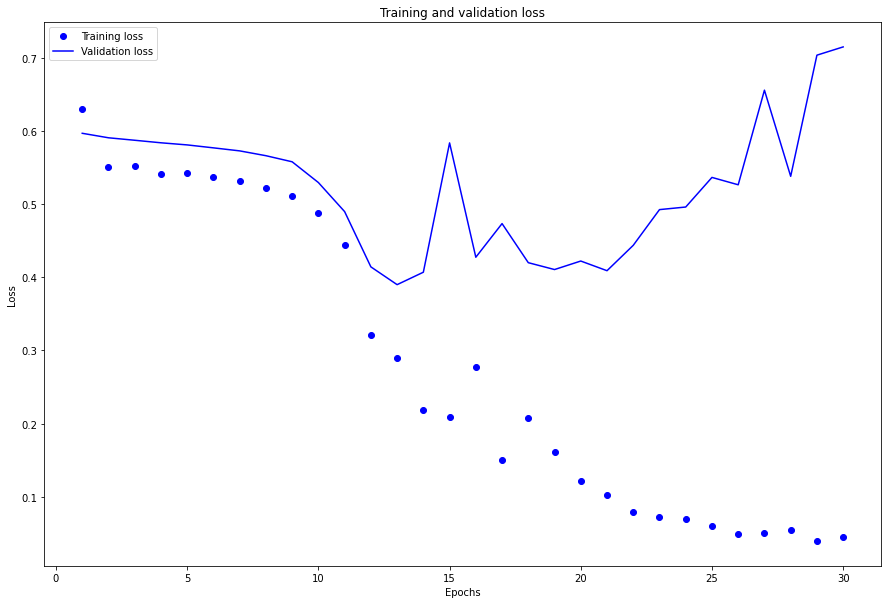

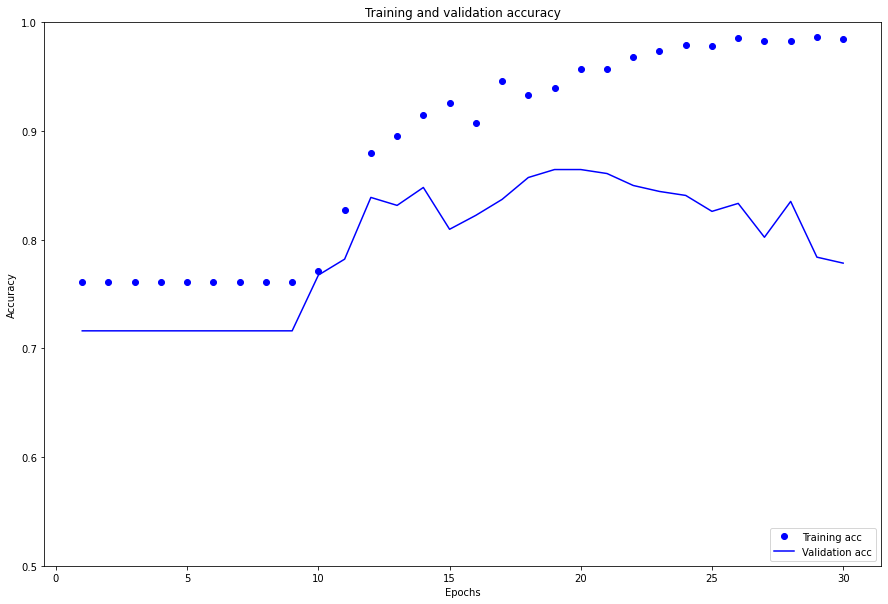

In [29]:
#plotting the accuracy and losses for our training and validation sets.
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [22]:
#Extract TSV files of the word embeddings, to be used with the embedding project http://projector.tensorflow.org/
import io

e = model.layers[0]
weights = e.get_weights()[0]

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()